In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler

class LogisticRegressionSGD():
    
    def __init__(self):
        self.w = None
        self.scaler = StandardScaler()
        
    def initialize(self, size):
        self.w = 1e-3*np.random.rand(size)

    def generate_batches(self, X, y, bs):
        for i in range(0, X.shape[0], bs):
            yield X[i:i+bs], y[i:i+bs]
    
    def loss(self, labels, X):
        return np.mean(np.log(1 + np.exp(np.multiply(-labels, X @ self.w))))
    
    def forward(self, X, mod=True):
        if mod:
            X = np.concatenate([np.ones((X.shape[0], 1)), self.scaler.fit_transform(X)], axis=1)
        return (1/(1+np.exp(-X @ self.w)))
    
    def backward(self, X, labels):
        grad = -(X.T @ np.divide(labels, 1 + np.exp(np.multiply(labels, (X @ self.w)))))/X.shape[0]
        self.w -= self.l_rate * grad
       
    def early_stop_fit(self, X_tr, y_tr, X_te, y_te, l_rate, n_epochs=100, bs=64, mod=True):
        if mod:
            X_tr = np.concatenate([np.ones((X_tr.shape[0], 1)),
                                  self.scaler.fit_transform(X_tr)], axis=1)
            X_te = np.concatenate([np.ones((X_te.shape[0], 1)),
                                  self.scaler.fit_transform(X_te)], axis=1)
        
        self.l_rate = l_rate
        self.initialize(X_tr.shape[1])
        self.stop = False
        
        self.train_loss = []
        self.test_loss = []
        
        self.train_acc = []
        self.test_acc = []
        
        self.train_roc = []
        self.test_roc = []

        for i in tqdm_notebook(range(n_epochs)):
            for X_batch, y_batch in self.generate_batches(X_tr, y_tr, bs):
                self.backward(X_batch, y_batch)
            self.train_loss.append(self.loss(y_tr, X_tr))
            self.test_loss.append(self.loss(y_te, X_te))
            
            out_tr = self.forward(X_tr, mod=False)
            out_te = self.forward(X_te, mod=False)
            
            self.train_roc.append(roc_auc_score(y_tr, out_tr))
            self.test_roc.append(roc_auc_score(y_te, out_te))
            
            self.train_acc.append(accuracy_score(y_tr, out_tr > 0.5))
            self.test_acc.append(accuracy_score(y_te, out_te > 0.5))
            
            if i >= 2:
                self.stop = True if self.test_loss[-1] >= self.test_loss[-2] else False
            if self.stop: 
                print(f'Early stopping at iteration {i}')
                break
        
        self.i = i
        self.n_epochs = n_epochs

    def plot(self, kind):
        if kind == 'loss':
            train = self.train_loss
            test = self.test_loss
            kind = 'Loss'
        elif kind == 'roc':
            train = self.train_roc
            test = self.test_roc
            kind = 'ROC AUC'
        elif kind == 'acc':
            train = self.train_acc
            test = self.test_acc
            kind = 'Accuracy'
        fig, ax = plt.subplots(figsize=[10, 10])
        fig.suptitle(f'Stooped at {self.i+1}th iteration of {self.n_epochs}\n{kind} plot')
        ax.plot(train, label='Train')
        ax.plot(test, label='Test')
        ax.set_xlabel('Iteration')
        ax.set_ylabel(kind)
        ax.legend()

In [54]:
plot_kinds = ['loss', 'roc', 'acc']

Early stopping occurs when $Loss_i$ > $Loss_{i-1}$, where $i$ is the iteration number.

# Cancer data:

In [60]:
df = pd.read_csv('Data/cancer.csv')
df['label'], _ = pd.factorize(df['label'])
labels = df['label'].values
num_data = df.drop(columns='label').values
X_tr, X_te, y_tr, y_te = train_test_split(num_data, labels, stratify=labels, test_size=0.3)

In [61]:
df['label'].value_counts()

1    357
0    212
Name: label, dtype: int64

In [62]:
model = LogisticRegressionSGD()
model.early_stop_fit(X_tr, y_tr, X_te, y_te, l_rate=0.1, n_epochs=20000, bs=16)

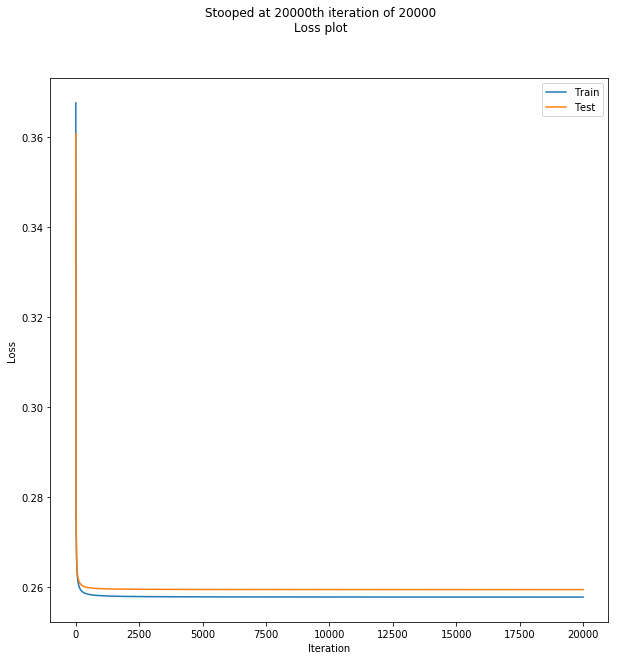

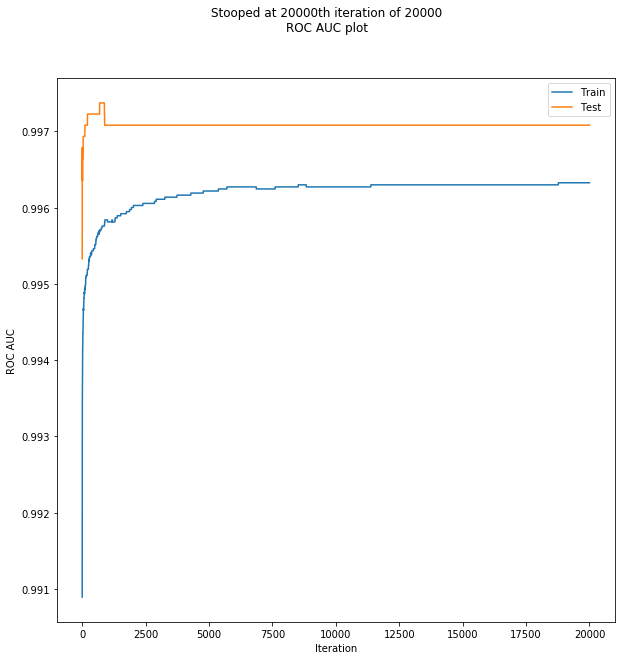

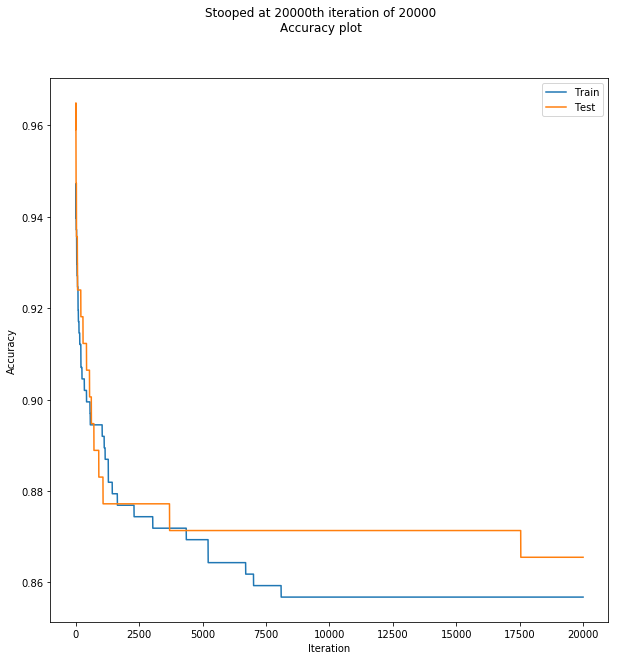

In [63]:
_ = list(map(model.plot, plot_kinds))

# Spam data:

In [64]:
df = pd.read_csv('Data/spam.csv')
df['label'], _ = pd.factorize(df['label'])
labels = df['label'].values
num_data = df.drop(columns='label').values
X_tr, X_te, y_tr, y_te = train_test_split(num_data, labels, stratify=labels, test_size=0.4)

In [65]:
df['label'].value_counts()

1    2788
0    1813
Name: label, dtype: int64

In [66]:
model = LogisticRegressionSGD()
model.early_stop_fit(X_tr, y_tr, X_te, y_te, l_rate=1, n_epochs=10000, bs=16)

Early stopping at iteration 372


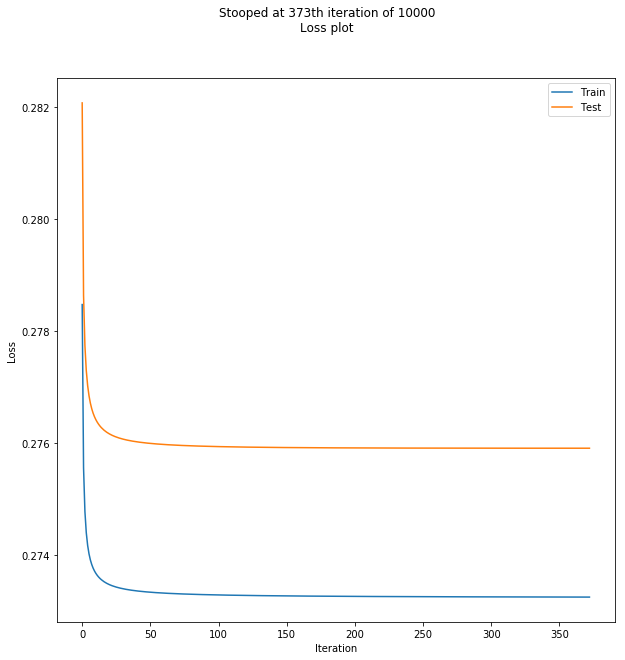

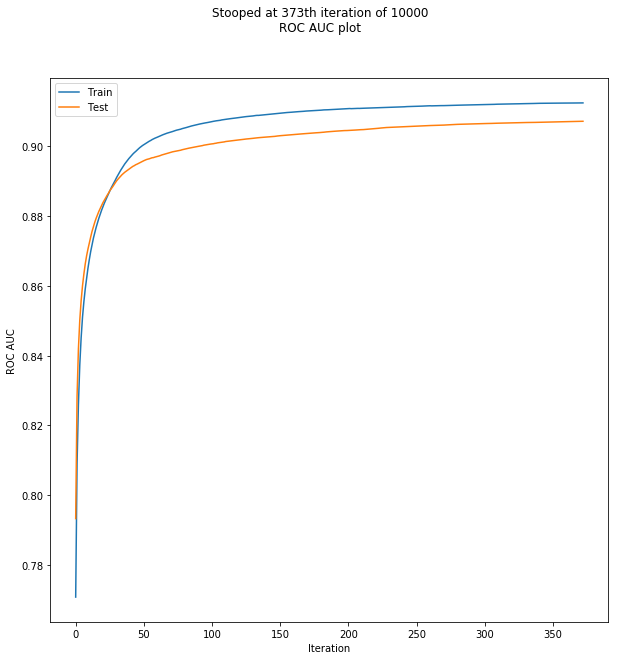

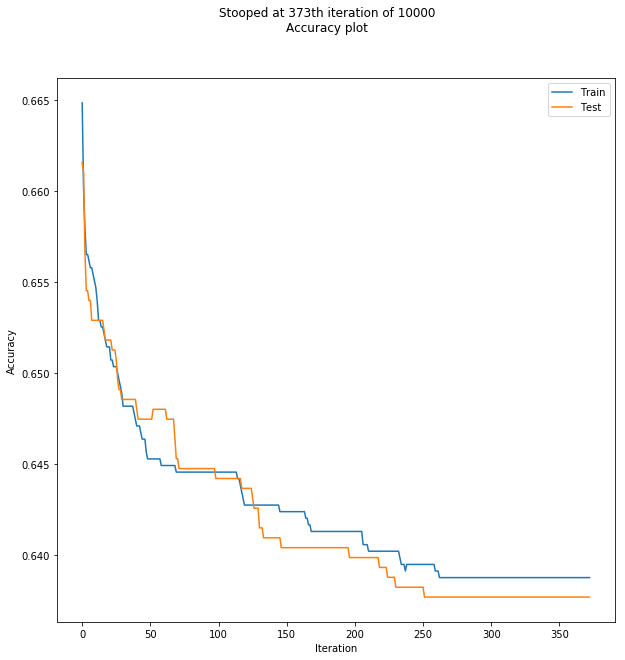

In [67]:
_ = list(map(model.plot, plot_kinds))

Accuracy drops during the learning process since both data sets have unbalanced classes, but the model works properly since both Loss and ROC AUC decrease.